In [52]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]
 

In [5]:
src = f"/home/andres/repos/rat-mapping-paper/reports/J_SHAP/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

In [94]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (4000, 8, 16, 4, 6)
b (4000, 8, 16, 4, 6)
L (4000, 8, 16, 4, 6)
ℓ (4000, 8, 16, 4, 6)
H (4000, 8, 16, 4, 6)


In [7]:
a = params[0]

In [95]:
a.shape

(4000, 8, 16, 4, 6)

In [56]:
subjects = df['participant'].unique()
subjects = sorted(encoder_dict['participant'].inverse_transform(subjects))
positions = df['compound_position'].unique()
positions = sorted(encoder_dict['compound_position'].inverse_transform(positions))
compound_charge = encoder_dict[model.features[2]].inverse_transform(sorted(df['compound_charge_params'].unique()))


In [59]:
compound_position = encoder_dict[model.features[1]].inverse_transform(sorted(df['compound_position'].unique()))
mono = [c for c in compound_position if c.split("-")[0] == "" or c.split("-")[1] == ""]

mono = np.array(mono[:3])

In [93]:
compound_charge

array(['20-0-80-25', '50-0-50-0', '50-0-50-100', '80-0-20-400'],
      dtype=object)

In [61]:
mono_inds = encoder_dict[model.features[1]].transform(mono)


In [12]:
mono

array(['-C6L', '-C7L', '-C8L', 'C6L-', 'C7L-', 'C8L-'], dtype='<U4')

In [13]:
cathode = [0,1,2] 
anode = [3,7,12]
mono_inds = [(0,1,2), (3,7,12)]

In [14]:
mono_inds

[(0, 1, 2), (3, 7, 12)]

In [15]:
a.shape

(4000, 8, 16, 4, 6)

In [98]:
compound_charge[:3]

array(['20-0-80-25', '50-0-50-0', '50-0-50-100'], dtype=object)

In [17]:
arr = []
for s, subject in enumerate(subjects):
    for k in mono_inds:
        a_temp = a[:, s, k, 1, :]
        arr.append(a_temp)

arr = np.array(arr)
arr = arr.reshape(len(subjects), len(mono_inds), *arr.shape[1:])

In [99]:
arr = a[:,:,mono_inds,:3,:]
arr = ma.masked_invalid(arr)

In [ ]:
arr

In [100]:
arr.shape

(4000, 8, 3, 3, 6)

In [145]:
a_norm = arr / ma.median(arr, axis=(2,3,4), keepdims=True)

In [102]:
a_norm.shape

(4000, 8, 3, 3, 6)

In [146]:
check_mean = ma.mean(a_norm, axis=(0,1,3,4))

In [147]:
check_mean.shape

(3,)

In [148]:
check_mean

masked_array(data=[1.2116370382518453, 1.1168407256437356,
                   1.111852067113053],
             mask=[False, False, False],
       fill_value=1e+20)

In [103]:
arr_norm_mean = ma.mean(a_norm, axis=0)

In [104]:
diffs = arr_norm_mean[:,:,:,None,:] - arr_norm_mean[:,:,None,:,:]

In [105]:
arr_norm_mean.shape

(8, 3, 3, 6)

In [106]:
means = ma.mean(arr_norm_mean, axis = (0,1,3))

In [119]:
test= ma.mean(arr_norm_mean, axis =3)

In [120]:
vals = []
for i in range(3):
    for j in range(3):
        if i == j:
            vals.append(1)
        else:
            vals.append(stats.wilcoxon(test[:,i,j], axis=0).pvalue)

In [121]:
vals

[1, 0.0625, 0.0625, 0.0078125, 1, 0.0078125, 0.25, 0.25, 1]

In [107]:
eff_means = means

In [136]:
arr_norm_mean.shape

(8, 3, 3, 6)

In [108]:
eff_sems = stats.sem(ma.mean(arr_norm_mean, axis = (1,3)))

In [92]:
encoder_dict['compound_charge_params'].inverse_transform([0,1,2,3])

array(['20-0-80-25', '50-0-50-0', '50-0-50-100', '80-0-20-400'],
      dtype=object)

In [135]:
eff_means

masked_array(data=[1.110232183601165, 1.1060140673511942,
                   1.2203413486254415],
             mask=[False, False, False],
       fill_value=1e+20)

In [110]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/J_SHAP/shape_selectivity_means.pkl"
with open(src, "rb") as f:
    charge_sel = pickle.load(f)

In [111]:
charge_sel.shape

(8, 3, 3)

In [112]:
charge_sel = ma.mean(charge_sel, axis=2)

In [113]:
charge_sel_sem = stats.sem(charge_sel, axis=0)

In [114]:
charge_sel_mean = ma.mean(charge_sel, axis=0)

In [115]:
charge_sel_mean

masked_array(data=[1.0563711637431505, 1.083255809256605,
                   1.0780029788112957],
             mask=[False, False, False],
       fill_value=1e+20)

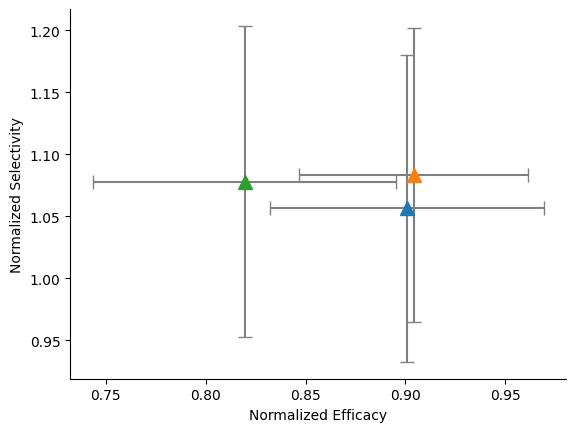

In [116]:
for i in range(3):
    plt.errorbar(x=1/eff_means[i], y=charge_sel_mean[i], yerr=charge_sel_sem[i], xerr=(eff_sems[i]/eff_means[i]**2), fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()   

In [41]:
cath_sel = cath_sel[:,1,:]
an_sel = an_sel[:,1,:]

In [43]:
cath_sel = ma.mean(cath_sel, axis=1)
an_sel = ma.mean(an_sel, axis=1)

In [44]:
cath_sel.shape

(8,)

In [39]:
cath_eff = cath_an[:,0]
an_eff = cath_an[:,1]

In [45]:
eff_avg_cath = ma.mean(cath_eff)
eff_avg_an = ma.mean(an_eff)

sel_avg_cath = ma.mean(cath_sel)
sel_avg_an = ma.mean(an_sel)

In [46]:
sem_eff_cath = stats.sem(cath_eff)
sem_eff_an = stats.sem(an_eff)

sem_sel_cath = stats.sem(cath_sel)
sem_sel_an = stats.sem(an_sel)

In [47]:
effs = [eff_avg_cath, eff_avg_an]
eff_sems = [sem_eff_cath, sem_eff_an]


sels = [sel_avg_cath, sel_avg_an]
sel_sems = [sem_sel_cath, sem_sel_an]

In [50]:
effs

[0.7039968547635649, 1.5666875115499295]

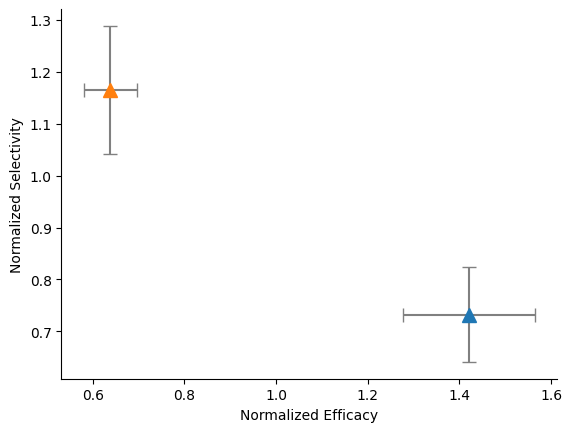

In [51]:
for i in range(len(effs)):
    plt.errorbar(x=1/effs[i], y=sels[i], yerr=sel_sems[i], xerr=(eff_sems[i]/effs[i]**2), fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()

In [48]:
effs

[0.7039968547635649, 1.5666875115499295]

In [29]:
labels = ["Cathode", "Anode"]
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(diffs_means[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))

<Axes: >

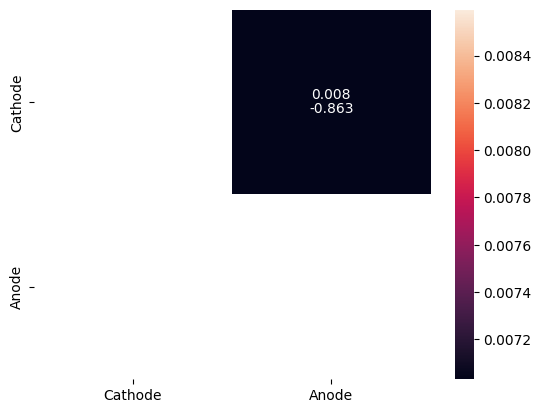

In [30]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(diffs_means.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [107]:
mono_inds = encoder_dict[model.features[1]].transform(mono)


In [108]:
mono_inds

array([0, 1, 2])

In [64]:
muscles = model.response

In [109]:
a.shape

(500, 8, 16, 4, 6)

In [110]:
b = ma.mean(a, axis=0)

In [113]:
b.shape

(8, 3, 4, 6)

In [112]:
b = b[:, mono_inds, :,:]

In [114]:
positions = sorted(df['compound_position'].unique())

In [116]:
subjects = encoder_dict["participant"].transform(subjects)

ValueError: y contains previously unseen labels: 0

In [119]:
target_list = []
for s in subjects:
    for p, pos in enumerate(mono):
        for m, ind in enumerate(muscles): 
            temp_max = np.max(b[s,p,:,m], axis = 0)
            for d in range(len(b[0,0,:,0])):
                if b[s,p,d,m] == temp_max:
                    target = d
                    target_list.append((target))

stats.mode(target_list)

ModeResult(mode=3, count=75)

In [120]:
mono

array(['-C6L', '-C7L', '-C8L'], dtype='<U4')

In [97]:
compound_charge

array(['20-0-80-25', '50-0-50-0', '50-0-50-100', '80-0-20-400'],
      dtype=object)

In [72]:
selec_a = a[:, :, mono_inds, :, :]

In [73]:
selec_a.shape

(500, 8, 6, 4, 6)

In [122]:
norm_y = []
norm_x = []

target = 3

for subject_ind, subject in enumerate(subjects):
    for m,muscle in enumerate(muscles):
    # Fix the subject index and size index
        a_temp = selec_a[:, subject_ind, :, :, m]
        mean_thres = np.nanmean(a_temp[:,:,target],axis=(0,1))
        curr_params = [
            params[:, subject_ind, mono_inds, :,m, None] for params in params
        ]

        x_temp = np.array([1.2*mean_thres])[None, None, None, None,:]

        temp_thresh = F.rectified_logistic(
            x_temp, #x_temp
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects),len(muscles),*norm_x.shape[2:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects),len(muscles),*norm_y.shape[2:])
norm_y = ma.masked_invalid(norm_y)

In [123]:
norm_y.shape

(8, 6, 3, 500, 4, 1)

In [125]:
y_means = ma.mean(norm_y, axis=(3,5))
y_means.shape #subjects, muscles, positions, charges

(8, 6, 3, 4)

In [126]:
y_diffs = y_means[:,:, :,:,None] - y_means[:,:,:,None,:]
y_diffs.shape

(8, 6, 3, 4, 4)

In [127]:
y_diffs_means = ma.mean(y_diffs,axis=(1,2))

In [ ]:
labels = ['20-0-80-25', '50-0-50-0', '50-0-50-100']
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(y_diffs_means[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))

In [124]:
vals = np.array(vals)

In [126]:
labels = ['20-0-80-25', '50-0-50-0', '50-0-50-100']

In [127]:
vals = vals.reshape(len(labels), len(labels))

In [129]:
vals.shape

(3, 3)

<Axes: >

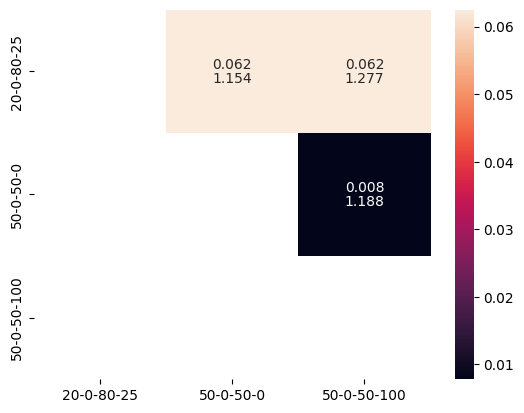

In [131]:
mask = np.tril(np.ones_like(vals), k=0).astype(bool)
sns.heatmap(vals, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(vals, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(test.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(vals, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(vals, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [134]:
test.shape

(8, 3, 3)